UGRID example: Add data from a coarser grid with a coarser time step to a fine grid with a finer time step. 

In this example we will:
* Combine a coarse and fine Delft3D FM model output result to use some of the output generated on the coarse model with the fine model output.
* Both models have different vertical layers, hence interpolation here is required.
* The output of the coarser model has a 5 day time step, the finer model a 1 day time step, add this data together as interpolation will give incorrect results (horizontal and vertical dispersion needs to be calculated by a model).
* Write the combined data to a new UGRID output file that can be used for postprocessing with D-Eco Impact.

In [39]:
#load required libraries and prepare logging
import os
import dfm_tools as dfmt
import xugrid as xu
import xarray as xr

#for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
import contextily as ctx
import math
import numpy as np
import scipy

import sys  
sys.path.insert(1, '../library')
from DEcoImpact_conv_func import DEIModel

plt.close()


In [2]:
#configuration
ds_in1  = r'..\tests\testdata\ugrid_netcdf\delft3dfmflow_output_example_DWSM-FM_100m_map.nc'             #input location of fine grid file that forms the basis for the output
ds_in2  = r'..\tests\testdata\ugrid_netcdf\delft3dfmflow_output_example_DCSM-FM_0_5nm_waq_map.nc'        #input location of coarse grid file that will be mapped to the fine grid output
ds_out  = r'input_DEI_delft3dfmflow_output_DWSMDCSMComb-FM_100m_map.nc'                                  #output location of file that can be loaded by D-Eco Impact
ds_out2 = r'input_DEI_delft3dfmflow_output_DCSMtoDWSM-FM_100m_map.nc'                                    #output location of file that can be loaded by D-Eco Impact

crs_code = "epsg:4326"                                                                                  #coordinate system applicable to files
                                                                                      
#variable mapping
uds2_to_uds1_variable_names = {"mesh2d_sa1"                     : "mesh2d_add_sa1",
                               "mesh2d_water_quality_output_1" : "mesh2d_add_ExtVI",
                               "mesh2d_water_quality_output_43": "mesh2d_add_RadSurf",
                               "mesh2d_water_quality_output_24": "mesh2d_add_IM1" ,
                               "mesh2d_water_quality_output_9" : "mesh2d_add_POC",
                               "mesh2d_DOC"                    : "mesh2d_add_DOC",
                               "mesh2d_water_quality_output_4" : "mesh2d_add_Phyt",
                               "mesh2d_MDIATOMS_E"             : "mesh2d_add_MDIATOMS_E"} # last one for testing purpose
                               

In [14]:
# load the fine model (sigma model) output and present the location of the data

## load the fine model output

uds1 = dfmt.open_partitioned_dataset(ds_in1)
print("time span: "+ str(uds1.time[0].values) + " - " + str(uds1.time[-1].values) + " , timesteps : " + str(len(uds1.time)))
print(uds1)

#check if "mesh2d_layer_sigma", "mesh2d_layer_z", "mesh2d_layer_sigma_z" is present
check_variable = ["mesh2d_layer_sigma", "mesh2d_layer_z", "mesh2d_layer_sigma_z"]
for check_var in check_variable: 
    print(str(check_var) + " in uds1 : "+ str(check_var in uds1.keys()))

#check if variables will be overwritten with mapping
new_var_in_uds1 = [varname for varname in uds2_to_uds1_variable_names.values() if varname in uds1.keys()]
if(len(new_var_in_uds1) > 0): print("Following variables will be overwritten with mapping to dataset uds1 : "+str(new_var_in_uds1))

#set coordinate system
uds1.ugrid.set_crs(crs_code)

>> xu.open_dataset() with 1 partition(s): 1 [10 nan fillvalue attrs removed][nodomainfname] : 0.07 sec
time span: 2017-06-01T00:00:00.000000000 - 2017-07-01T00:00:00.000000000 , timesteps : 31
<xarray.Dataset> Size: 17MB
Dimensions:                         (time: 31, mesh2d_nInterfaces: 11,
                                     mesh2d_nLayers: 10, mesh2d_nNodes: 350,
                                     mesh2d_nFaces: 312,
                                     mesh2d_nMax_face_nodes: 4,
                                     mesh2d_nEdges: 661)
Coordinates:
  * time                            (time) datetime64[ns] 248B 2017-06-01 ......
    mesh2d_node_x                   (mesh2d_nNodes) float64 3kB dask.array<chunksize=(350,), meta=np.ndarray>
    mesh2d_node_y                   (mesh2d_nNodes) float64 3kB dask.array<chunksize=(350,), meta=np.ndarray>
    mesh2d_face_x                   (mesh2d_nFaces) float64 2kB dask.array<chunksize=(312,), meta=np.ndarray>
    mesh2d_face_y            

In [15]:
# load the coarse model (z sigma model) output and present the location of the data

## load the coarse model output

uds2 = dfmt.open_partitioned_dataset(ds_in2)
print("time span: "+ str(uds2.time[0].values) + " - " + str(uds2.time[-1].values) + " , timesteps : " + str(len(uds2.time)))
print(uds2)

#check if "mesh2d_layer_sigma", "mesh2d_layer_z", "mesh2d_layer_sigma_z", "mesh2d_bldepth" is present
check_variable = ["mesh2d_layer_sigma", "mesh2d_layer_z", "mesh2d_layer_sigma_z", "mesh2d_bldepth"]
for check_var in check_variable: 
    print(str(check_var) + " in uds2 : "+ str(check_var in uds2.keys()))

#check if variables mentioned are present in dataset
not_var_uds2 = [varname for varname in uds2_to_uds1_variable_names.keys() if varname not in uds2.keys()]
if(len(not_var_uds2) > 0): print("Following variables do not exist in mapping dataset uds2 : "+str(not_var_uds2))

#set coordinate system
uds2.ugrid.set_crs(crs_code)

>> xu.open_dataset() with 1 partition(s): 1 [16 nan fillvalue attrs removed][nodomainfname] : 0.47 sec
time span: 2017-06-05T00:00:00.000000000 - 2017-06-30T00:00:00.000000000 , timesteps : 6
<xarray.Dataset> Size: 16MB
Dimensions:                         (time: 6, mesh2d_nInterfaces: 51,
                                     mesh2d_nLayers: 50, mesh2d_nNodes: 66,
                                     mesh2d_nFaces: 50,
                                     mesh2d_nMax_face_nodes: 4,
                                     mesh2d_nEdges: 115)
Coordinates:
    mesh2d_layer_sigma_z            (mesh2d_nLayers) float64 400B dask.array<chunksize=(50,), meta=np.ndarray>
  * time                            (time) datetime64[ns] 48B 2017-06-05 ... ...
    mesh2d_node_x                   (mesh2d_nNodes) float64 528B dask.array<chunksize=(66,), meta=np.ndarray>
    mesh2d_node_y                   (mesh2d_nNodes) float64 528B dask.array<chunksize=(66,), meta=np.ndarray>
    mesh2d_face_x               

zsigma-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here
[default_fillvals decoded for 19 variables] sigma-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here


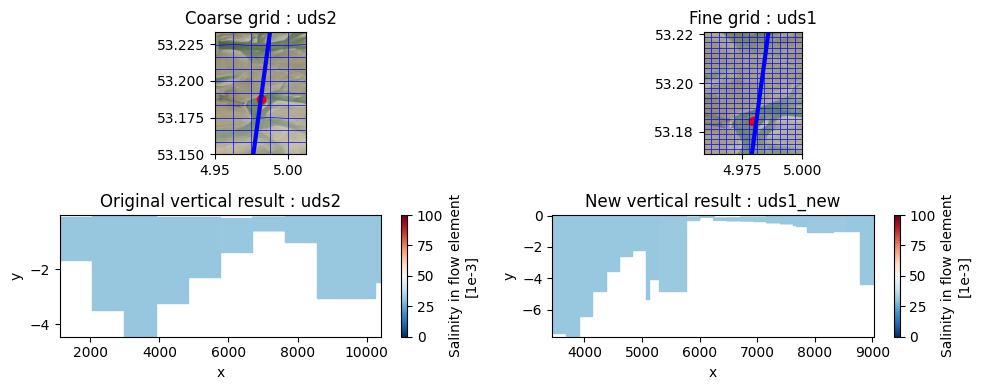

In [41]:
## present the location of the fine model and coars model grid
crs = 'EPSG:4326'
line_array = np.array([[4.975, 53.14],[4.99, 53.25]]) #transect line

#make transect values
uds2_crs = dfmt.polyline_mapslice(uds2.isel(time=3), line_array)
uds1_new_crs = dfmt.polyline_mapslice(uds1.isel(time=19), line_array)

test_face_uds2_x = uds2["mesh2d_face_x"].isel(mesh2d_nFaces = 27).values
test_face_uds2_y = uds2["mesh2d_face_y"].isel(mesh2d_nFaces = 27).values 
test_face_uds1_x = uds1["mesh2d_face_x"].isel(mesh2d_nFaces = 38).values
test_face_uds1_y = uds1["mesh2d_face_y"].isel(mesh2d_nFaces = 38).values

#set up plot
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(10,4))#, sharex = True)
((ax1, ax2), (ax3, ax4)) = axs

kwargs_plot = {'cmap':'RdBu_r' ,'vmin': 0.0, 'vmax': 100.0}

#Plot coarse grid
pc1 = uds2.grid.plot(edgecolor='blue', linewidth=0.5, ax= ax1)
ax1.scatter(x = test_face_uds2_x, y = test_face_uds2_y, color='red')
ctx.add_basemap(ax=ax1, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax1.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)
ax1.set_title('Coarse grid : uds2')

#Plot fine grid
pc2 = uds1.grid.plot(edgecolor='blue', linewidth=0.5, ax= ax2)
ax2.scatter(x = test_face_uds1_x, y = test_face_uds1_y, color='red')
ctx.add_basemap(ax=ax2, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax2.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)
ax2.set_title('Fine grid : uds1')

#Plot slice of uds2 salinity
pc3 = uds2_crs.mesh2d_sa1.ugrid.plot(ax = ax3, **kwargs_plot)
ax3.set_title('Original vertical result : uds2')

#Plot slice of uds1_new salinity
pc4 = uds1_new_crs.mesh2d_sa1.ugrid.plot(ax = ax4, **kwargs_plot)
ax4.set_title('New vertical result : uds1_new')

#indicate sharing of axis
#ax2.sharex(ax1); ax4.sharex(ax3)

#some plotting configuration for a nice layout
plt.tight_layout()

plt.show()

In [45]:
# Retrieve the sigma z coordinate of each layer per face of input uds1

#get z position of each face
face_layer_z_uds1 = -1 * uds1.mesh2d_flowelem_bl * uds1.mesh2d_layer_sigma
face_layer_z_uds1 = face_layer_z_uds1.assign_coords(mesh2d_nLayers = uds1.mesh2d_nLayers.values)

#get x y location of each face
face_centroids_xy_uds1 = uds1.ugrid.grid.centroids
face_centroids_x_uds1 , face_centroids_y_uds1 = zip(*face_centroids_xy_uds1)

#store them in a dataset
face_layer_z_uds1["mesh2d_face_x"] = xr.DataArray(face_centroids_x_uds1[0], coords=[uds1.mesh2d_nFaces.values], dims = "mesh2d_nFaces")
face_layer_z_uds1["mesh2d_face_y"] = xr.DataArray(face_centroids_y_uds1[0], coords=[uds1.mesh2d_nFaces.values], dims = "mesh2d_nFaces")
    
#name the variable of the dataarray
face_layer_z_uds1 = face_layer_z_uds1.rename("mesh2d_face_z")  

print(face_layer_z_uds1)

#allocate face z to the dataset
uds1["mesh2d_face_z"] = face_layer_z_uds1


<xarray.DataArray 'mesh2d_face_z' (mesh2d_nFaces: 312, mesh2d_nLayers: 10)> Size: 25kB
dask.array<mul, shape=(312, 10), dtype=float64, chunksize=(312, 10), chunktype=numpy.ndarray>
Coordinates:
    mesh2d_face_x   (mesh2d_nFaces) float64 2kB 4.998 4.998 ... 4.998 4.998
    mesh2d_face_y   (mesh2d_nFaces) float64 2kB 53.19 53.19 ... 53.19 53.19
  * mesh2d_nLayers  (mesh2d_nLayers) int64 80B 0 1 2 3 4 5 6 7 8 9
  * mesh2d_nFaces   (mesh2d_nFaces) int64 2kB 0 1 2 3 4 ... 307 308 309 310 311


In [46]:
# Retrieve the sigma z coordinate of each layer per face of input uds2 (as we stick to the shallow area we do not need the mesh2d_layer_z)
# uds2 contains the layer mesh2d_sigma_layer_z coordinate, but this checks the method

#get z position of each face
face_layer_z_uds2 = -1 * uds2.mesh2d_flowelem_bl * uds2.mesh2d_layer_sigma
face_layer_z_uds2 = face_layer_z_uds2.assign_coords(mesh2d_nLayers = uds2.mesh2d_nLayers.values)

#get x y location of each face
face_centroids_xy_uds2 = uds2.ugrid.grid.centroids
face_centroids_x_uds2 , face_centroids_y_uds2 = zip(*face_centroids_xy_uds2)

#store them in a dataset
face_layer_z_uds2["mesh2d_face_x"] = xr.DataArray(face_centroids_x_uds2[0], coords=[uds2.mesh2d_nFaces.values], dims = "mesh2d_nFaces")
face_layer_z_uds2["mesh2d_face_y"] = xr.DataArray(face_centroids_y_uds2[0], coords=[uds2.mesh2d_nFaces.values], dims = "mesh2d_nFaces")

#name the variable of the dataarray
face_layer_z_uds2 = face_layer_z_uds2.rename("mesh2d_face_z")  

print(face_layer_z_uds2)

#allocate face z to the dataset
uds2["mesh2d_face_z"] = face_layer_z_uds2

<xarray.DataArray 'mesh2d_face_z' (mesh2d_nFaces: 50, mesh2d_nLayers: 50)> Size: 20kB
dask.array<mul, shape=(50, 50), dtype=float64, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
    mesh2d_face_x         (mesh2d_nFaces) float64 400B 5.006 5.006 ... 5.006
    mesh2d_face_y         (mesh2d_nFaces) float64 400B 53.23 53.23 ... 53.23
    mesh2d_layer_sigma_z  (mesh2d_nLayers) float64 400B dask.array<chunksize=(50,), meta=np.ndarray>
  * mesh2d_nLayers        (mesh2d_nLayers) int64 400B 0 1 2 3 4 ... 46 47 48 49
  * mesh2d_nFaces         (mesh2d_nFaces) int64 400B 0 1 2 3 4 ... 46 47 48 49


In [47]:
#regrid the data based on different regridder techniques
uds2_to_uds1_regridded_face_z = xu.CentroidLocatorRegridder(source = uds2, target = uds1).regrid(uds2.mesh2d_face_z)
uds2_to_uds1_regridded_diatoms1 = xu.OverlapRegridder(source = uds2, target = uds1, method="mean").regrid(uds2.mesh2d_MDIATOMS_E)
uds2_to_uds1_regridded_diatoms2 = xu.BarycentricInterpolator(source = uds2, target = uds1).regrid(uds2.mesh2d_MDIATOMS_E)
uds2_to_uds1_regridded_diatoms3 = xu.CentroidLocatorRegridder(source = uds2, target = uds1).regrid(uds2.mesh2d_MDIATOMS_E)

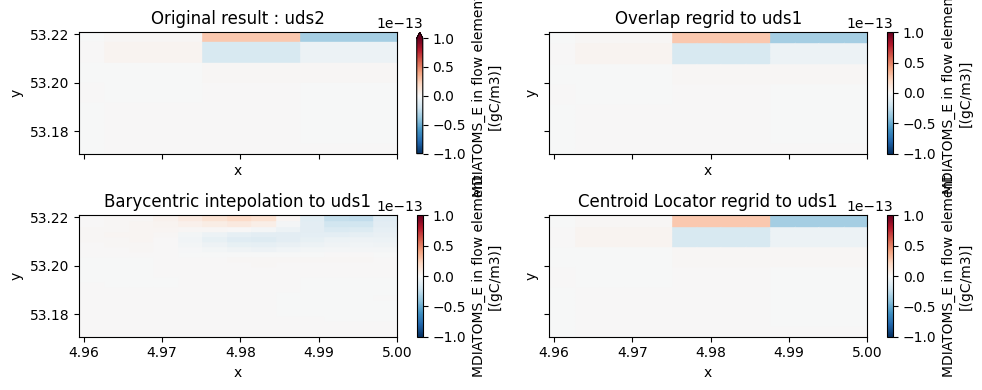

In [49]:
#plot difference in regridding techniques
## present the location of the fine model and coars model grid
crs = 'EPSG:4326'
line_array = None
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(10,4), sharex = True, sharey = True)
((ax1, ax2), (ax3, ax4)) = axs

kwargs_plot = {'cmap':'RdBu_r' ,'vmin': -1.0e-13, 'vmax': 1.0e-13}

#Plot coarse grid uds2 for mesh2d_MDIATOMS_E
pc1 = uds2.mesh2d_MDIATOMS_E.isel(time = 3, mesh2d_nLayers = 49).ugrid.plot(ax= ax1, **kwargs_plot)
#ctx.add_basemap(ax=ax1, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax1.set_title('Original result : uds2')

#Plot regridding with Overlap from uds2 to uds1 for mesh2d_MDIATOMS_E
pc2 = uds2_to_uds1_regridded_diatoms1.isel(time = 3, mesh2d_nLayers = 49).ugrid.plot(ax = ax2, **kwargs_plot)
#ctx.add_basemap(ax=ax2, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax2.set_title('Overlap regrid to uds1')

#Plot regridding with BarycentricInterpolator
pc3 = uds2_to_uds1_regridded_diatoms2.isel(time = 3, mesh2d_nLayers = 49).ugrid.plot(ax = ax3, **kwargs_plot)
#ctx.add_basemap(ax=ax2, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax3.set_title('Barycentric intepolation to uds1')

#Plot regridding with CentroidLocatorRegridder
pc4 = uds2_to_uds1_regridded_diatoms3.isel(time = 3, mesh2d_nLayers = 49).ugrid.plot(ax = ax4, **kwargs_plot)
#ctx.add_basemap(ax=ax2, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax4.set_title('Centroid Locator regrid to uds1')

#some plotting configuration for a nice layout
plt.tight_layout()

plt.show()

In [50]:
#regrid the data for each variable
def regrid_function(uds_source, uds_target, xu_function, varnames, xu_method = "mean"):
    if(xu_function == "OverlapRegridder"):
        regridder = xu.OverlapRegridder(source = uds_source, target = uds_target, method=xu_method)
    elif(xu_function == "CentroidLocatorRegridder"):
        regridder = xu.CentroidLocatorRegridder(source = uds_source, target = uds_target)
    elif(xu_function == "BarycentricInterpolator"):
        regridder = xu.CentroidLocatorRegridder(source = uds_source, target = uds_target)
    else:
        raise ValueError("xu_function should be any of existing xugrid regridding functions : " +\
                          str(["OverlapRegridder", "CentroidLocatorRegridder","BarycentricInterpolator"]))
    
    l_regridded = []
    if(isinstance(varnames,str)):
       varnames = [varnames]
    for varname in varnames:
        dataarray = regridder.regrid(uds_source[varname])
        dataset = dataarray.to_dataset(name = varname)
        l_regridded.append(dataset)
    
    #merge regridded arrays
    if(len(l_regridded)>1):
        uds_regridded = xu.merge(l_regridded)
    else:
        uds_regridded = l_regridded[0]
        
    return(uds_regridded)

#regrid mesh2d_face_z to add depth
uds2_to_uds1_regridded_face_z = regrid_function(uds2, uds1, "CentroidLocatorRegridder",["mesh2d_face_z", "mesh2d_bldepth"])

#regridded all the variabels and add to one dataset
#drop_these_vars = [var for var in uds2.data_vars if var not in list(uds2_to_uds1_variable_names.keys())]
#regridded_vars = uds2.drop_vars(drop_these_vars).map(
#    lambda uds2_var: 
uds2_to_uds1_regridded = regrid_function(
        uds_source = uds2,
        uds_target = uds1,
        xu_function = "OverlapRegridder",
        varnames = list(uds2_to_uds1_variable_names.keys()),
        xu_method = "mean"
    )

#Add mesh2d_face_z and other regridded vertical coordinates to dataset
uds2_to_uds1_regridded["mesh2d_face_z"] = uds2_to_uds1_regridded_face_z.mesh2d_face_z
uds2_to_uds1_regridded["mesh2d_bldepth"] = uds2_to_uds1_regridded_face_z.mesh2d_bldepth

#Add layering from original file
uds2_to_uds1_regridded["mesh2d_layer_sigma_z"] = uds2.mesh2d_layer_sigma_z
uds2_to_uds1_regridded["mesh2d_layer_sigma"] = uds2.mesh2d_layer_sigma
uds2_to_uds1_regridded["mesh2d_sigmazdepth"] = uds2.mesh2d_sigmazdepth
uds2_to_uds1_regridded["mesh2d_layer_z"] = uds2.mesh2d_layer_z


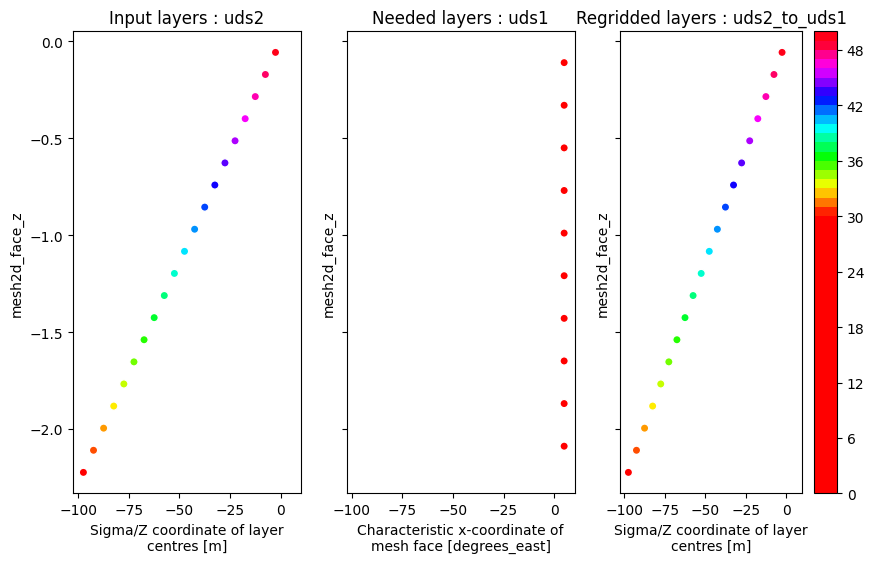

In [51]:
#plot differences in depth between fine grid (uds1) and coarse grid (uds2)
crs = 'EPSG:4326'
line_array = None
fig, axs = plt.subplots(ncols = 3, figsize=(10,6), sharex = True, sharey = True)
(ax1, ax2, ax3) = axs

#omit nan cells that do not contian data (Z-layers)
uds2_with_data = uds2.mesh2d_face_z.isel(mesh2d_nFaces = 27).where(uds2.mesh2d_MDIATOMS_E.isel(
    time = 0, mesh2d_nFaces = 27).notnull().compute(), drop = True)
uds2_to_uds1_regridded_with_data = uds2_to_uds1_regridded.mesh2d_face_z.isel(mesh2d_nFaces = 38).where(uds2_to_uds1_regridded.mesh2d_MDIATOMS_E.isel(
    time = 0, mesh2d_nFaces = 38).notnull().compute(), drop = True)

#normalize colour scale
vmin = min(uds2_with_data.mesh2d_nLayers.values)
vmax = max(uds2_with_data.mesh2d_nLayers.values)

#make colourmap
cmap = plt.cm.hsv
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
print(norm)
sm = mpl.ScalarMappable(cmap=cmap, norm=norm) 

#Plot coarse grid uds2 for mesh2d_face_z
pc1 = uds2_with_data.plot.scatter(
    x = None, 
    c = cmap(norm(uds2_with_data.mesh2d_nLayers.values)),
    norm = norm, 
    ax= ax1, **kwargs_plot)
ax1.set_title('Input layers : uds2')

#Plot fine grid uds1 for mesh2d_face_z
pc2 = uds1.mesh2d_face_z.isel(mesh2d_nFaces = 38).plot.scatter(
    x = None, 
    c = cmap(norm(uds1.mesh2d_nLayers.values)),
    norm = norm,  
    ax = ax2, **kwargs_plot) 
ax2.set_title('Needed layers : uds1')

#Plot fine grid uds1 for mesh2d_face_z
pc3 = uds2_to_uds1_regridded_with_data.plot.scatter(
        x= None, 
        c = cmap(norm(uds2_with_data.mesh2d_nLayers.values)),
        norm = norm,  
        ax = ax3, **kwargs_plot)
ax3.set_title('Regridded layers : uds2_to_uds1')

plt.colorbar(sm, boundaries = np.linspace(0,50,51), ax=plt.gca())
plt.show()

In [52]:
## Test the interpolation of one face for one timestep to compare later result

#get the face_z values for the specific face
depth_test_face = uds2_to_uds1_regridded.mesh2d_face_z.isel(mesh2d_nFaces = 38).where(uds2_to_uds1_regridded.mesh2d_MDIATOMS_E.isel(
    time = 0, mesh2d_nFaces = 38).notnull().compute(), drop = True).values

diatoms_test_face = uds2_to_uds1_regridded.mesh2d_MDIATOMS_E.isel(time = 3, mesh2d_nFaces = 38).where(uds2_to_uds1_regridded.mesh2d_MDIATOMS_E.isel(
    time = 0, mesh2d_nFaces = 38).notnull().compute(), drop = True).values

new_depth_test_face = uds1.isel(mesh2d_nFaces = 38).mesh2d_face_z.values

print("orginal depth    : min - " + str(min(depth_test_face)) + ", max - " + str(max(depth_test_face)) + ", len - " + str(len(depth_test_face)))
print("diatom value     : min - " + str(min(diatoms_test_face)) + ", max - " + str(max(diatoms_test_face)) + ", len - " + str(len(diatoms_test_face)))
print("new depth        : min - " + str(min(new_depth_test_face)) + ", max - " + str(max(new_depth_test_face))  + ", len - " + str(len(new_depth_test_face)))
interpreted = np.interp(new_depth_test_face, depth_test_face, diatoms_test_face)
print("new diatom value : min - " + str(min(interpreted)) + ", max - " + str(max(interpreted)) + ", len - " + str(len(interpreted)))
print(interpreted)

orginal depth    : min - -2.223949447274212, max - -0.05702434480190279, len - 20
diatom value     : min - -1.6573256078431933e-17, max - 1.4012383915739828e-17, len - 20
new depth        : min - -2.0888196969696975, max - -0.10993787878787904, len - 10
new diatom value : min - -1.2724049114769093e-17, max - 5.745219179937368e-18, len - 10
[ 1.38902366e-18 -1.11472606e-18  3.69302141e-18 -1.27240491e-17
 -3.23987257e-18 -4.71914199e-18 -8.99751254e-18 -9.14284818e-18
 -2.72415757e-18  5.74521918e-18]


In [53]:
import xarray as xr
import numpy as np
import numba

#when used in a script use numba.njit to accelarate the function
@numba.njit#(nopython =  True, parallel = True)
def group_faces_interp1d_np(data_in, og_depth_in, new_depth_in):
    
    ''''
    do a vertical interpolation based on a specific structure of the
     input data. Interpolate to a new mesh2d_nLayers and mask non active layers.
     - data_in : numpy ndarray ('time','mesh2d_nLayers','mesh2d_nFaces')
     - og_depth_in : numpy ndarray ('mesh2d_nLayers','mesh2d_nFaces')
     - new_depth_in : numpy ndarray ('mesh2d_nLayers','mesh2d_nFaces')
    
     output:
     - out_array3D : numpy ndarray ('mesh2d_nLayers','time','mesh2d_nFaces')
    '''
    
    out_array3D = np.empty((
        new_depth_in.shape[0],
        data_in.shape[0], 
        data_in.shape[2]
    ))

    for face in range(0,data_in.shape[2]):
        for time in range(0,data_in.shape[0]):
            mask = ~np.isnan(data_in[time,:,face])
            if(np.any(mask)):
                #if not all nan interpolate where possible, otherwise nan
                out = np.interp(
                    new_depth_in[:,face],
                    og_depth_in[:,face][mask],
                    data_in[time,:,face][mask],
                )
            else:
                #if all nan fill array completley with nan values
                out = np.full(shape=len(new_depth_in[:,face]), fill_value=np.nan)
            
            out_array3D[:, time, face] = out
     
    return(out_array3D)    


# Data preperation
data = uds2_to_uds1_regridded.chunk({"mesh2d_nFaces": "auto"})
og_depth_data = uds2_to_uds1_regridded.mesh2d_face_z.chunk({"mesh2d_nFaces": "auto"})
new_depth_data = uds1.mesh2d_face_z.chunk({"mesh2d_nFaces": "auto"})

# Loop over variables and groupby Faces and apply interpolation
for nr, varname in enumerate(list(uds2_to_uds1_variable_names.keys())):
    temp_data = group_faces_interp1d_np(
        data_in = data[varname].values,
        og_depth_in = og_depth_data.values,
        new_depth_in = new_depth_data.transpose().values,
    )            
    
    #make dataarray and transfer attributes
    new_data_array = xr.DataArray(
         temp_data,
         dims = ["mesh2d_nLayers","time","mesh2d_nFaces"],
         attrs = data[varname].attrs,
    )
    
    #make dataset
    temp_dataset = new_data_array.to_dataset(name = varname)
    if(nr == 0):
        new_dataset = temp_dataset
    else:
        new_dataset = xr.merge([new_dataset, temp_dataset])

# Rename variables
new_dataset = new_dataset.rename(uds2_to_uds1_variable_names)

# Transpose to original dimension order
new_dataset = new_dataset.transpose("time", "mesh2d_nLayers", "mesh2d_nFaces")

# Re-add depth layers, and bounds for positions and time values
new_dataset["mesh2d_face_z"] = (("mesh2d_nFaces", "mesh2d_nLayers"), face_layer_z_uds1)
new_dataset["time"] = uds2_to_uds1_regridded.time

# Convert back to UGRID dataset
uds_ds_new = xu.UgridDataset(new_dataset, grids=uds1.grids)

print(uds_ds_new)
print(uds_ds_new.mesh2d_add_MDIATOMS_E.isel(time=3, mesh2d_nFaces=38).values)

<xarray.Dataset> Size: 1MB
Dimensions:                (time: 6, mesh2d_nLayers: 10, mesh2d_nFaces: 312)
Coordinates:
  * time                   (time) datetime64[ns] 48B 2017-06-05 ... 2017-06-30
  * mesh2d_nFaces          (mesh2d_nFaces) int64 2kB 0 1 2 3 ... 308 309 310 311
Dimensions without coordinates: mesh2d_nLayers
Data variables:
    mesh2d_add_sa1         (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB ...
    mesh2d_add_ExtVI       (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB ...
    mesh2d_add_RadSurf     (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB ...
    mesh2d_add_IM1         (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB ...
    mesh2d_add_POC         (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB ...
    mesh2d_add_DOC         (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB ...
    mesh2d_add_Phyt        (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB ...
    mesh2d_add_MDIATOMS_E  (time, mesh2d_nLayers, mesh2d_nFaces) float64 150kB 

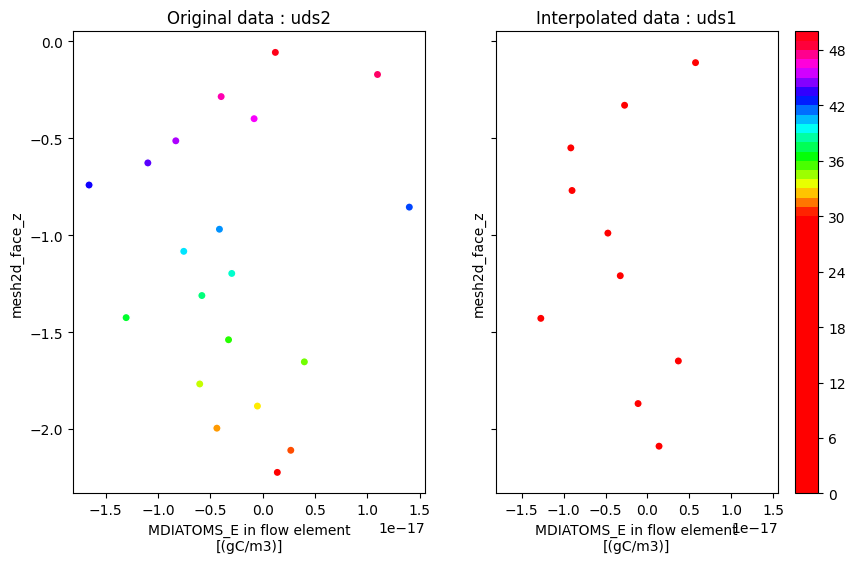

In [54]:
#plot differences in depth between fine grid (uds1) and coarse grid (uds2) for diatoms
crs = 'EPSG:4326'
line_array = None
fig, axs = plt.subplots(ncols = 2, figsize=(10,6), sharex = True, sharey = True)
(ax1, ax2) = axs

#omit nan cells that do not contian data (Z-layers) and select only the test face and test timestep
vertical_data_uds2 = uds2[["mesh2d_face_z","mesh2d_MDIATOMS_E"]].isel(time = 3, mesh2d_nFaces = 27).where(uds2.mesh2d_MDIATOMS_E.isel(
    time = 0, mesh2d_nFaces = 27).notnull().compute(), drop = True)
vertical_data_regridded = uds_ds_new[["mesh2d_face_z","mesh2d_add_MDIATOMS_E"]].isel(
    time = 3, mesh2d_nFaces = 38).rename({"mesh2d_add_MDIATOMS_E":"mesh2d_MDIATOMS_E"})

#normalize colour scale
vmin = min(uds2_with_data.mesh2d_nLayers.values)
vmax = max(uds2_with_data.mesh2d_nLayers.values)

#make colourmap
cmap = plt.cm.hsv
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
print(norm)
sm = mpl.ScalarMappable(cmap=cmap, norm=norm) 

#Plot coarse grid uds2 for mesh2d_face_z
pc1 = vertical_data_uds2.plot.scatter(
    y = 'mesh2d_face_z',
    x = 'mesh2d_MDIATOMS_E', 
    c = cmap(norm(uds2_with_data.mesh2d_nLayers.values)),
    norm = norm, 
    ax= ax1, **kwargs_plot)
ax1.set_title('Original data : uds2')

#Plot fine grid uds1 for mesh2d_face_z
pc2 = vertical_data_regridded.plot.scatter(
    y = 'mesh2d_face_z',
    x = 'mesh2d_MDIATOMS_E', 
    c = cmap(norm(uds1.mesh2d_nLayers.values)),
    norm = norm,  
    ax = ax2, **kwargs_plot) 
ax2.set_title('Interpolated data : uds1')

plt.colorbar(sm, boundaries = np.linspace(0,50,51), ax=plt.gca())
plt.show()

In [55]:
# The course grid (5 days) and fine grid (1 day) have a differtent timestep.
# Interpolation over the timestep would not give accurate modelled results (how to interpolate, when horizontal and vertical dispersion plays a role)
# Hence to utilize the detail of both datasets, not existing data on other timesteps is kept blank (nan).

uds1_new = xu.merge([uds1,uds_ds_new])

#check if the data has been well allocated based on time
print(uds_ds_new.mesh2d_add_MDIATOMS_E.isel(time = 3, mesh2d_nFaces = 38, mesh2d_nLayers = 9).values)
print(uds_ds_new.mesh2d_add_MDIATOMS_E.isel(time = 3, mesh2d_nFaces = 38, mesh2d_nLayers = 9).time.values)
print(uds1_new.mesh2d_add_MDIATOMS_E.isel(time = 19, mesh2d_nFaces = 38, mesh2d_nLayers = 9).values)
print(uds1_new.mesh2d_add_MDIATOMS_E.isel(time = 19, mesh2d_nFaces = 38, mesh2d_nLayers = 9).time.values)
print(uds1_new.coords)

5.745219179937368e-18
2017-06-20T00:00:00.000000000
5.745219179937368e-18
2017-06-20T00:00:00.000000000
Coordinates:
  * time            (time) datetime64[ns] 248B 2017-06-01 ... 2017-07-01
  * mesh2d_nLayers  (mesh2d_nLayers) int64 80B 0 1 2 3 4 5 6 7 8 9
    mesh2d_node_x   (mesh2d_nNodes) float64 3kB dask.array<chunksize=(350,), meta=np.ndarray>
    mesh2d_node_y   (mesh2d_nNodes) float64 3kB dask.array<chunksize=(350,), meta=np.ndarray>
    mesh2d_face_x   (mesh2d_nFaces) float64 2kB dask.array<chunksize=(312,), meta=np.ndarray>
    mesh2d_face_y   (mesh2d_nFaces) float64 2kB dask.array<chunksize=(312,), meta=np.ndarray>
    mesh2d_edge_x   (mesh2d_nEdges) float64 5kB dask.array<chunksize=(661,), meta=np.ndarray>
    mesh2d_edge_y   (mesh2d_nEdges) float64 5kB dask.array<chunksize=(661,), meta=np.ndarray>
  * mesh2d_nEdges   (mesh2d_nEdges) int64 5kB 0 1 2 3 4 ... 656 657 658 659 660
  * mesh2d_nFaces   (mesh2d_nFaces) int64 2kB 0 1 2 3 4 ... 307 308 309 310 311
  * mesh2d_nNodes  

zsigma-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here
[default_fillvals decoded for 21 variables] sigma-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here


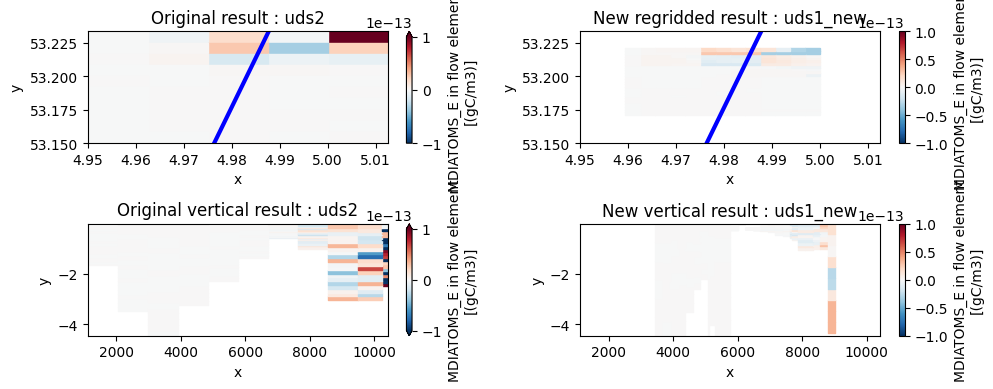

In [57]:
#plot final result
#plot difference in regridding techniques
## present the location of the fine model and coars model grid
crs = 'EPSG:4326'
line_array = np.array([[4.975, 53.14],[4.99, 53.25]]) #transect line

#make transect values
uds2_crs = dfmt.polyline_mapslice(uds2.isel(time=3), line_array)
uds1_new_crs = dfmt.polyline_mapslice(uds1_new.isel(time=19), line_array)


fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(10,4))
((ax1, ax2), (ax3, ax4)) = axs

kwargs_plot = {'cmap':'RdBu_r' ,'vmin': -1.0e-13, 'vmax': 1.0e-13}

#Plot coarse grid uds2 for mesh2d_MDIATOMS_E
pc1 = uds2.mesh2d_MDIATOMS_E.isel(time = 3, mesh2d_nLayers = 49).ugrid.plot(ax= ax1, **kwargs_plot)
#ctx.add_basemap(ax=ax1, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax1.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)
ax1.set_title('Original result : uds2')

#Plot regridding result from uds2 to uds1 for mesh2d_MDIATOMS_E
pc2 = uds1_new.mesh2d_add_MDIATOMS_E.isel(time = 19, mesh2d_nLayers = 9).ugrid.plot(ax = ax2, **kwargs_plot)
#ctx.add_basemap(ax=ax2, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
ax2.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)
ax2.set_title('New regridded result : uds1_new')

#Plot slice of uds2
pc3 = uds2_crs.mesh2d_MDIATOMS_E.ugrid.plot(ax = ax3, **kwargs_plot)
ax3.set_title('Original vertical result : uds2')

#Plot slice of uds1_new
pc4 = uds1_new_crs.mesh2d_add_MDIATOMS_E.ugrid.plot(ax = ax4, **kwargs_plot)
ax4.set_title('New vertical result : uds1_new')

#indicate sharing of axis
ax2.sharex(ax1); ax2.sharey(ax1)
ax4.sharex(ax3); ax4.sharey(ax3)

#some plotting configuration for a nice layout
plt.tight_layout()

plt.show()

In [58]:
#Export complete results
#initialize
DEI = DEIModel()
cwd = os.getcwd()
DEI.set_root(root = cwd)



#read Netcdf
DEI._mesh2d = uds1_new


#export result
DEI.write_mesh(fn_temp = "example_output_data/temporary_file.nc", fn_ecoimpact = "example_output_data/"+ds_out)

print("Done.")

Done.


In [59]:
#Export intermediate results on large timestep
#initialize
DEI2 = DEIModel()
cwd = os.getcwd()
DEI2.set_root(root = cwd)



#read Netcdf
DEI2._mesh2d = uds_ds_new


#export result
DEI2.write_mesh(fn_temp = "example_output_data/temporary_file.nc", fn_ecoimpact = "example_output_data/"+ds_out2)

print("Done.")

Done.
